In [66]:
from enum import auto, StrEnum
import re

import requests
from requests_cache import CachedSession

from urllib.parse import quote
from urllib.request import urlopen

import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams["figure.figsize"] = (10, 10)


class Preset(StrEnum):
    duel = auto()
    team = auto()
    ffa = auto()
    all = auto()


preset = Preset.team
season0: bool = True


In [2]:
# Cache the data
def get_data(url: str):
    session = CachedSession("bar_cache", backend="sqlite")
    data = session.get(url).json()
    return data

In [3]:
# Get user name from user id
def get_user_name(user_id: int):
    name_list = get_data("https://api.bar-rts.com/cached-users")
    user_name = ""
    for user in name_list:
        if user["id"] == user_id:
            user_name = user["username"]
    return user_name

def get_user_id(user_name: str):
    name_list = get_data("https://api.bar-rts.com/cached-users")
    user_id = ""
    for user in name_list:
        if user["username"] == user_name:
            user_id = user["id"]
    return user_id

In [4]:
def process_match_data(match_details_df):
    # Get the winning team and count the number of wins
    match = {}
    matches = []

    for _, game in match_details_df.iterrows():
        # print(game)
        for team in game["AllyTeams"]:
            for player in team["Players"]:
                match = {
                    **match,
                    **{
                        "id": team["id"],
                        "userId": player["userId"],
                        "teamId": player["teamId"],
                        "allyTeamId": player["allyTeamId"],
                        "name": player["name"],
                        "faction": player["faction"],
                        "rank": player["rank"],
                        "skillUncertainty": player["skillUncertainty"],
                        "skill": float(re.sub("[^0123456789\.]", "", player["skill"])),
                        "startPos": player["startPos"],
                        "winningTeam": team["winningTeam"],
                        "Map.fileName": game["Map.fileName"]
                        + "_"
                        + str(len(team["Players"]))
                        + "v"
                        + str(len(team["Players"])),
                        "Map.scriptName": game["Map.scriptName"],
                        "durationMs": game["durationMs"],
                        "startTime": game["startTime"],
                    },
                }
                matches.append(match)

    matches_df = pd.json_normalize(matches)
    matches_df["startTime"] = pd.to_datetime(matches_df["startTime"])
    return matches_df


# Get match details for each match
def get_match_details(id: str):
    match_details = get_data(f"https://api.bar-rts.com/replays/{id}")

    match_details_df = pd.json_normalize(match_details)
    match_details_df["startTime"] = pd.to_datetime(match_details_df["startTime"])
    return match_details_df

In [5]:
# Get the players replays metadata
def get_match_data(user: str, preset: Preset = Preset.all):
    # Depending on the preset, the API returns different data.json
    # The preset uses the following format: &preset=duel%2Cffa%2Cteam
    # duel%2Cffa%2Cteam is the same as duel,ffa,team

    if preset == Preset.all:
        preset = "&preset=duel&preset=ffa&preset=team"
    else:
        preset = f"&preset={preset.name}"

    uri = f"https://api.bar-rts.com/replays?page=1&limit=9999{preset}&hasBots=false&endedNormally=true&players="

    data = get_data(f"{uri}{quote(user)}")

    # Get the winning team and count the number of wins
    matches = []

    for game in data["data"]:
        if game["Map"]["fileName"] is not None:
            matches.append(get_match_details(game["id"]))
            
    matches_df = pd.concat(matches, axis=0)
    return matches_df

In [6]:
matches_details_df = process_match_data(get_match_data("furyhawk"))

In [7]:
matches_details_df

,id,userId,teamId,allyTeamId,name,faction,rank,skillUncertainty,skill,winningTeam,Map.fileName,Map.scriptName,durationMs,startTime,startPos.x,startPos.y,startPos.z
0,715941,4040,5,715941,Karunel,Armada,3,3.0,26.74,False,flats_and_forests_v2.1_8v8,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,11646.758789,217.387939,3440.973145
1,715941,101939,4,715941,Litschi,Armada,5,3.0,33.98,False,flats_and_forests_v2.1_8v8,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,10197.106445,207.090332,7777.133789
2,715941,1256,2,715941,sneyed,Armada,5,3.0,38.58,False,flats_and_forests_v2.1_8v8,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,11631.319336,224.760742,8888.593750
3,715941,53682,3,715941,fiddler112,Cortex,5,3.0,35.35,False,flats_and_forests_v2.1_8v8,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,11715.701172,210.979980,11950.851562
4,715941,92112,6,715941,BattleMoose,Armada,3,3.0,25.46,False,flats_and_forests_v2.1_8v8,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,10247.027344,225.524170,1518.017456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2081,512454,57139,11,512454,[DSM]UnInstallLyf,Cortex,2,3.0,18.10,True,all_that_glitters_1.2_8v8,All That Glitters v1.2,1777500,2023-05-01 08:58:22+00:00,1167.000000,193.704346,602.000000
2082,512454,40640,12,512454,DSA,Cortex,3,3.0,17.39,True,all_that_glitters_1.2_8v8,All That Glitters v1.2,1777500,2023-05-01 08:58:22+00:00,4387.000000,193.763672,2203.000000
2083,512454,57580,13,512454,Rastabortionist,Cortex,0,3.0,15.16,True,all_that_glitters_1.2_8v8,All That Glitters v1.2,1777500,2023-05-01 08:58:22+00:00,3253.000000,194.605225,2316.000000
2084,512454,94078,14,512454,SentoN,Armada,0,3.0,12.72,True,all_that_glitters_1.2_8v8,All That Glitters v1.2,1777500,2023-05-01 08:58:22+00:00,1079.191772,200.370239,2367.832031


In [8]:
# Get the win rate for each map
def get_win_rate(user: str, min_games: int = 5, season0: bool = False):
    
    df = process_match_data(get_match_data(user, PRESET))
    if season0:
        df = df[df["startTime"] >= "2023-06-01"]
    win_rate = (
        df.query(f"userId == {get_user_id(user)}")
        .groupby(["Map.fileName"])
        .agg({"winningTeam": ["mean", "count"]})["winningTeam"]
        .query(f"count > {str(min_games)}")
        .sort_values([("mean"), ("count")], ascending=True)
    )
    return win_rate

In [64]:
# Set the x axis minor locator to 5 and major locator to 10
# Set the y axis to the map name
def plot_win_rate(user: str, min_games: int = 5, season0: bool = False):
    win_rate = get_win_rate(user, min_games, season0)
    if win_rate.empty:
        print(f"{user} has not played enough games")
        return

    # Get overall win rate
    overall_win_rate = win_rate["mean"].mean()
    # Get total number of games
    total_games = win_rate["count"].sum()

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey="all", figsize=(12, 6))

    bars = ax1.barh(
        y=win_rate.index,
        width=win_rate["mean"],
        alpha=0.75,
    )
    ax1.bar_label(bars, fmt="{:.0%}", label_type="center")
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.grid(which="minor", axis="x", linestyle="--")
    ax1.grid(which="major", axis="x", linestyle="-")
    ax1.set_xlabel("Winning %")
    ax1.set_ylabel("Map")
    ax1.set_xlim(0, 1)
    ax1.set_title(f"[{preset.name} games]{user} Winning {overall_win_rate:.0%} by Map")

    ax1.set_axisbelow(True)

    bars = ax2.barh(
        y=win_rate.index,
        width=win_rate["count"],
        alpha=0.75,
    )

    ax2.bar_label(bars, label_type="center")
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.grid(which="minor", axis="x", linestyle="--")
    ax2.grid(which="major", axis="x", linestyle="-")
    ax2.set_xlabel("Games")
    ax2.set_title(f"{user} {total_games} games by Map")

    plt.subplots_adjust(wspace=0, hspace=0)

    return fig

In [9]:
get_win_rate("furyhawk")

,mean,count
Map.fileName,,
Rosetta1.4_8v8,0.333333,6
koom_valley_3_3.1_8v8,0.333333,6
all_that_glitters_v2.1_8v8,0.500000,6
ice_scream_v2.5_8v8,0.500000,8
all_that_glitters_v2.0_8v8,0.500000,10
supreme_strait_v1.4_8v8,0.600000,40
dsdr_4.1_8v8,0.700000,10


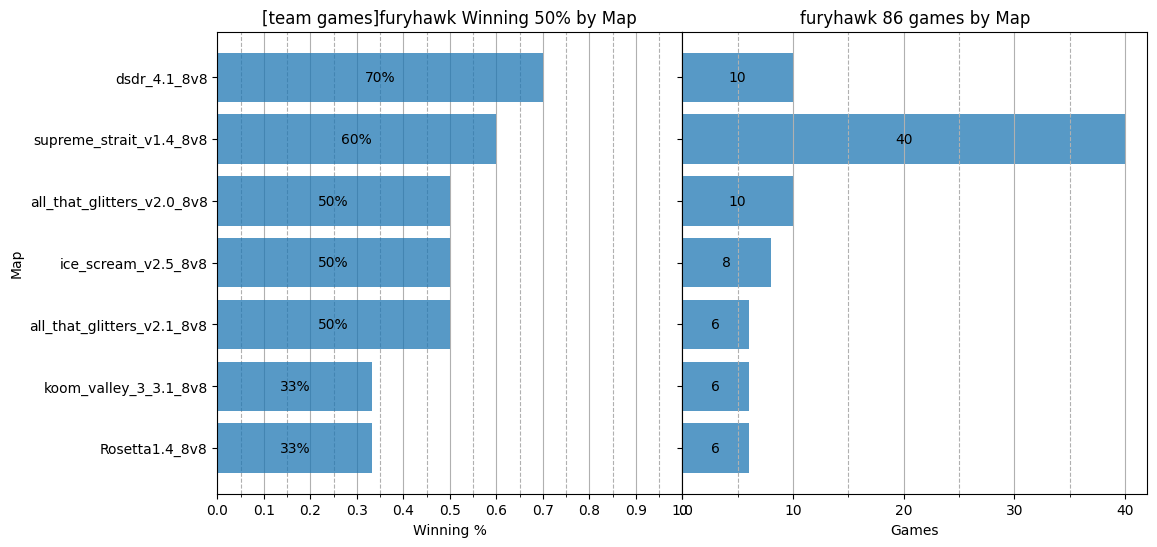

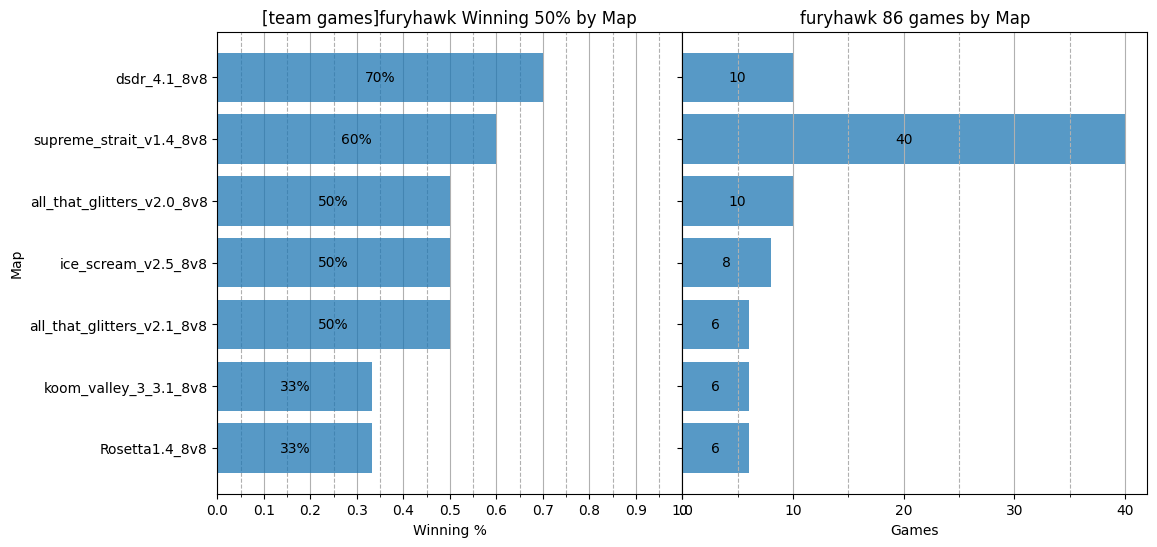

In [67]:
plot_win_rate("furyhawk")

In [10]:
df = process_match_data(get_match_data("furyhawk", PRESET))
if season0:
    df = df[df["startTime"] >= "2023-06-01"]

    

In [11]:
df

,id,userId,teamId,allyTeamId,name,faction,rank,skillUncertainty,skill,winningTeam,Map.fileName,Map.scriptName,durationMs,startTime,startPos.x,startPos.y,startPos.z
0,715941,4040,5,715941,Karunel,Armada,3,3.0,26.74,False,flats_and_forests_v2.1_8v8,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,11646.758789,217.387939,3440.973145
1,715941,101939,4,715941,Litschi,Armada,5,3.0,33.98,False,flats_and_forests_v2.1_8v8,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,10197.106445,207.090332,7777.133789
2,715941,1256,2,715941,sneyed,Armada,5,3.0,38.58,False,flats_and_forests_v2.1_8v8,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,11631.319336,224.760742,8888.593750
3,715941,53682,3,715941,fiddler112,Cortex,5,3.0,35.35,False,flats_and_forests_v2.1_8v8,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,11715.701172,210.979980,11950.851562
4,715941,92112,6,715941,BattleMoose,Armada,3,3.0,25.46,False,flats_and_forests_v2.1_8v8,Flats and Forests v2.1,1004467,2023-07-06 13:26:31+00:00,10247.027344,225.524170,1518.017456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,616367,96033,12,616367,lolfindkeinnamen,Cortex,2,3.0,16.17,True,supreme_strait_v1.4_8v8,Supreme Strait v1.4,2066500,2023-06-01 14:28:39+00:00,4535.524902,59.813599,7434.944824
723,616367,83880,13,616367,Ambassador,Armada,3,3.0,14.79,True,supreme_strait_v1.4_8v8,Supreme Strait v1.4,2066500,2023-06-01 14:28:39+00:00,3944.423584,62.832031,9278.013672
724,616367,88793,10,616367,ThePasst,Armada,3,3.0,18.00,True,supreme_strait_v1.4_8v8,Supreme Strait v1.4,2066500,2023-06-01 14:28:39+00:00,972.909546,265.818604,10482.109375
725,616367,19953,9,616367,PaniniPie,Cortex,5,3.0,20.45,True,supreme_strait_v1.4_8v8,Supreme Strait v1.4,2066500,2023-06-01 14:28:39+00:00,4863.265137,55.085083,8604.011719


In [19]:
(
    df #.query(f"userId == {get_user_id('furyhawk')}")
    .groupby(["allyTeamId", "userId"])
    .agg({"winningTeam": ["mean", "count"]}) 
    # .query(f"count > {str(5)}")
    # .sort_values([("mean"), ("count")], ascending=True)
)

winningTeam      
                         mean count
allyTeamId userId                  
616367     19953          1.0     1
           48295          1.0     1
           81893          1.0     1
           83880          1.0     1
           86458          1.0     1
...                       ...   ...
715941     8202           0.0     1
           53682          0.0     1
           92112          0.0     1
           101939         0.0     1
           116739         0.0     1

[727 rows x 2 columns]

In [13]:
# Get allyTeamId of userId



(
    df.query(f"userId == {get_user_id('furyhawk')}")
    .groupby(["faction"])
    .agg({"winningTeam": ["mean", "count"]}) 
    
    # .query(f"count > {str(5)}")
    # .sort_values([("mean"), ("count")], ascending=True)
)

winningTeam      
               mean count
faction                  
Armada     0.581395    43
Cortex     1.000000     1

In [32]:
team_winrate = (
    df.groupby(  # .query(f"userId == {get_user_id('furyhawk')}")
        ["allyTeamId", "userId"]
    ).agg({"winningTeam": ["mean", "count"]})
    # .query(f"count > {str(5)}")
    # .sort_values([("mean"), ("count")], ascending=True)
)

In [34]:
team_winrate

winningTeam      
                         mean count
allyTeamId userId                  
616367     19953          1.0     1
           48295          1.0     1
           81893          1.0     1
           83880          1.0     1
           86458          1.0     1
...                       ...   ...
715941     8202           0.0     1
           53682          0.0     1
           92112          0.0     1
           101939         0.0     1
           116739         0.0     1

[727 rows x 2 columns]

In [43]:
# From team_winrate, get the allyTeamId of the user

team_ally_id = team_winrate.query(f"userId == {get_user_id('furyhawk')}").index.unique(level='allyTeamId')


In [44]:
team_ally_id

Index([616368, 616448, 618891, 619031, 621263, 624391, 624612, 625201, 625809,
       634699, 636952, 637063, 637171, 637254, 643421, 650347, 650434, 650669,
       650722, 650773, 661855, 661932, 668434, 668489, 672706, 672803, 675547,
       678271, 680605, 682820, 682863, 683007, 683056, 683270, 693750, 693775,
       693871, 696222, 697659, 700494, 700739, 704685, 715664, 715940],
      dtype='int64', name='allyTeamId')

In [47]:
teams_df = df[df['allyTeamId'].isin(team_ally_id)]

In [61]:
teams_df.groupby(["name"]).agg({"winningTeam": ["mean", "count"]})["winningTeam"].sort_values([("mean"), ("count")], ascending=False).head(5)

,mean,count
name,,
EmperorGlass,1.0,4
Raikoh,1.0,3
SadPanda,1.0,3
Analogue,1.0,2
Desker,1.0,2


In [57]:
get_user_name(78769)

'Raikoh'

In [68]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-07-08'

In [75]:
data={'data': [{'id': 1,} ]}

In [78]:
if hasattr(data, 'data'):
    print('no')